In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
np.random.seed(100)

# 近似ベイズ推論：サンプリングに基づく推論手法
- パラメータの推論が解析的に行えないケースがある
  - e.g. モデルが複雑、非線形、共役関係にない分布でモデルを設計
- サンプリングに基づく推論：求めたい分布$p(\Theta | \mathcal{D})$から何らかの方法でサンプルを得ることで、その分布の統計的性質をしる

ここでは、サンプリングに基づく近似推論の一つとして、高次元の空間で効率的にサンプリングを行う手段である「マルコフ連鎖モンテカルロ法(Markov chain Monte Carlo method, MCMC)」と呼ばれている手法を実装してみる。
MCMC法はいくつかのアルゴリズムが提案されている。ここでは、最も基本的なアルゴリズムである「メトロポリス法(Metropolis method)」を実装する。

MCMC法のアイディアは、サンプルを取り出したい分布が定常分布$p(z)$に分布収束するような遷移確率$p(z_t | z_{t-1})$を設計するというアイディアで作られている。

## メトロポリス法(Metropolis method)

### アルゴリズム
- サンプルを得たい目標分布 : $p(z)$
- 目標分布に比例する正規化されていない分布 : $p(z) \propto \tilde{p}(z)$
- 遷移確率 : $p(z | z^{\prime})$
  - 遷移確率が直接設計することが難しい場合には、遷移の提案分布を使う : $q(z | z^{\prime})$

以下の手順でサンプルを取得する。

1. 提案分布$q(z | z^{t})$から次のサンプル候補$z_*$をサンプル
2. 比率rを計算
$$
r = \frac{\tilde{p}(z_*)q(z^{(t)}|z_{*})}{\tilde{p}(z^{(t)})q(z_*|z^{(t)})}
$$
3. 確率min(1,r)に従って$z_*$を受容（$z^{(t+1)}=z_*$）し、受容されない場合は$z^{(t+1)}=z^{(t)}$とする
4. 繰り返し

実は上記の手順は、「メトロポリス・ヘイスティングス法(Metropolis-Hastings method)」と呼ばれるアルゴリズムである。手順2において、提案分布$q(z | z^{\prime})$が対称であれば、比率rの式で約分される。この場合が特に「メトロポリス法」と呼ばれている。

この比率rは、サンプル候補$z_*$の尤度$\tilde{p}(z_*)$が高いほど受容されやすくなるということを表している。比率rに従って受容されるか否かが決まるので、確率が低い場合にも受容されることが有り得る。そのため、尤度の山を行ったりきたりしながら登っていくようにイメージできる（と思っている）。

### 問題設定
データ$\mathbf{X}=\{x_1, x_2, \cdots, x_N\}$はベルヌーイ分布$\mathrm{Bern}(x | \theta)$に従うとする。
パラメータ$\theta$はベータ分布$\mathrm{Beta}(\theta | a, b)$に従うとする。
N個のデータ$X$を観測した場合のパラメータ$\theta$の事後分布$p(\theta | X)$推論したい。

この問題を解くために、目標分布$p(\theta | X)$に比例する分布$\tilde{p}(z)$は$p(X | \theta)p(\theta)$となる。

$$
\begin{eqnarray}
  p(\theta | X) &=& \frac{p(X | \theta)p(\theta)}{p(X)} \\
    &\propto& p(X | \theta)p(\theta)
\end{eqnarray}
$$

サンプルzの値域は[0,1]なので、提案分布として一様分布を用いる。一様分布は前の状態に依存しないので、$q(z | z^{\prime}) = q(z^{\prime} | z)$であり、対称である。


### 解析解
この問題の場合、ベータ分布とベルヌーイ分布は共役関係にあるため、事後分布$p(\theta | X)$は厳密解を求めることができる(計算略)。

$$
\begin{eqnarray}
  p(\theta | X) &\propto& p(X | \theta)p(\theta) \\
    &=& \left\{ \prod^{N}_{n=1} p(x_n | \theta) \right\} p(\theta) \\
    &=& \mathrm{Beta}(\theta | \hat{a}, \hat{b})
\end{eqnarray}
$$

ここで、

$$
\begin{eqnarray}
  &\hat{a}& = \sum^{N}_{n=1} x_n + a \\
  &\hat{b}& = N - \sum^{N}_{n=1} x_n + b
\end{eqnarray}
$$

### 実装

#### テストデータ

In [3]:
# テストデータ
theta = 0.1
N = 100
X = stats.bernoulli.rvs(p=theta, size=N)
print(X)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


#### 解析解


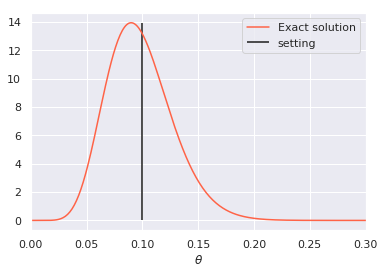

In [4]:
a = 1.0
b = 1.0

a_hat = a + np.sum(X)
b_hat = b + N - np.sum(X)
analysis_dist = stats.beta(a=a_hat, b=b_hat)
ts = np.linspace(0, 1, 1000)
tt = analysis_dist.pdf(ts)

fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)
ax.plot(ts, tt, color='#ff6347', label='Exact solution')
ax.vlines(theta, 0, max(tt), label='setting')
ax.set_xlabel('$\\theta$')
ax.set_xlim([0, 0.3])
plt.legend()

#### メトロポリス法

In [5]:
%%time
# モデル
## 提案分布
proposal = stats.uniform(loc=0, scale=1)
## 尤度
p_tilde_lik = stats.bernoulli
a = 1
b = 1
p_tilde_pri = stats.beta(a=a, b=b)
def lik(X, z):
    lik = np.prod(p_tilde_lik.pmf(k=X, p=z))
    prior = p_tilde_pri.pdf(z)
    p_tilde = lik * prior
    return p_tilde

## メトロポリス法
n_sample = 1000
zs = []
zt = p_tilde_pri.rvs()
cnt = 0
pbar = tqdm(total=n_sample)
while len(zs) < n_sample:
    # 提案分布からサンプリング
    z = proposal.rvs()
    # 比率の計算
    r = lik(X, z) / lik(X, zt)
    # 受容判定
    u = stats.uniform.rvs(loc=0, scale=1)
    if u < r:
        zs.append(z)
        zt = z
        pbar.update(1)
    cnt+=1
    if cnt>n_sample*100:
        print('over iter')
        break
pbar.close()

100%|██████████| 1000/1000 [00:06<00:00, 158.05it/s]

CPU times: user 6.24 s, sys: 405 ms, total: 6.64 s
Wall time: 6.33 s


In [6]:
# accept_rate = n_sample / cnt
print('accept rate = {}/{}={}'.format(n_sample, cnt, accept_rate))

accept rate = 1000/10699=0.09346667912889055


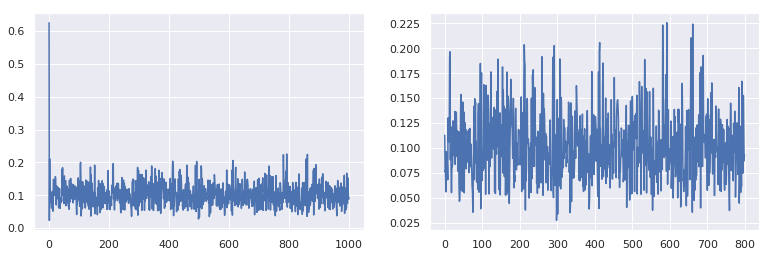

In [7]:
n_burn = 200

fig = plt.figure(figsize=(13, 4))
ax = fig.subplots(1,2)

ax[0].plot(zs)
ax[1].plot(zs[n_burn:])

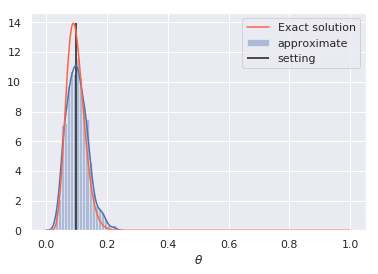

In [8]:
bins = np.arange(0, 1.0, 0.01)

fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)

sns.distplot(zs[n_burn:], bins=bins, ax=ax, label='approximate')
ax.plot(ts, tt, color='#ff6347', label='Exact solution')
ax.vlines(theta, 0, max(tt), label='setting')
ax.set_xlabel('$\\theta$')
plt.legend()